In [20]:
import numpy as np
import matplotlib.pyplot as plt
!pip install datasets
from datasets import load_dataset
from sklearn.decomposition import PCA
from PIL import Image

# Q1
## i)

In [21]:
# Load the MNIST dataset from Hugging Face
dataset = load_dataset('mnist', split='train')

# Ensure all images are properly converted to NumPy arrays
X = np.array([np.array(image) for image in dataset['image']])  # Convert PIL images to NumPy arrays
y = np.array(dataset['label'])  # Extract labels

# Randomly select 1000 images (100 per class)
np.random.seed(42)
selected_indices = np.concatenate([
    np.random.choice(np.where(y == i)[0], 100, replace=False) for i in range(10)
])
X_selected = X[selected_indices]
y_selected = y[selected_indices]
print(X_selected.shape)
# Normalize the dataset (pixel values between 0 and 1)
X_selected = X_selected / 255.0

(1000, 28, 28)


In [22]:
def pca(data, num_components):
    # Step 1: Mean-center the data
    data_2d = data.reshape(data.shape[0], -1)  # Flatten images before PCA
    mean = np.mean(data_2d, axis=0)
    centered_data = data_2d - mean

    # Step 2: Compute covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Step 3: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 4: Sort eigenvectors by eigenvalues (descending)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Select top `num_components` eigenvectors
    selected_vectors = eigenvectors[:, :num_components]

    # Step 6: Project data
    reduced_data = np.dot(centered_data, selected_vectors)
    return reduced_data, selected_vectors, mean, eigenvalues


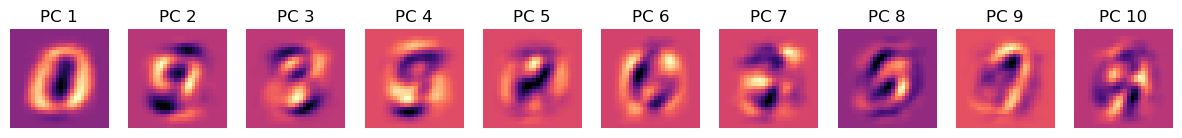

In [23]:
# Perform PCA to extract principal components
num_components = 10
reduced_data, principal_components, mean, eigenvalues = pca(X_selected, num_components)

# Plot the first few principal components
fig, axes = plt.subplots(1, num_components, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(principal_components[:, i].reshape(28, 28), cmap='magma')
    ax.axis('off')
    ax.set_title(f'PC {i+1}')
plt.show()


In [24]:
def reconstruct_data(reduced_data, principal_components, mean):
    return np.dot(reduced_data, principal_components.T) + mean

## ii)

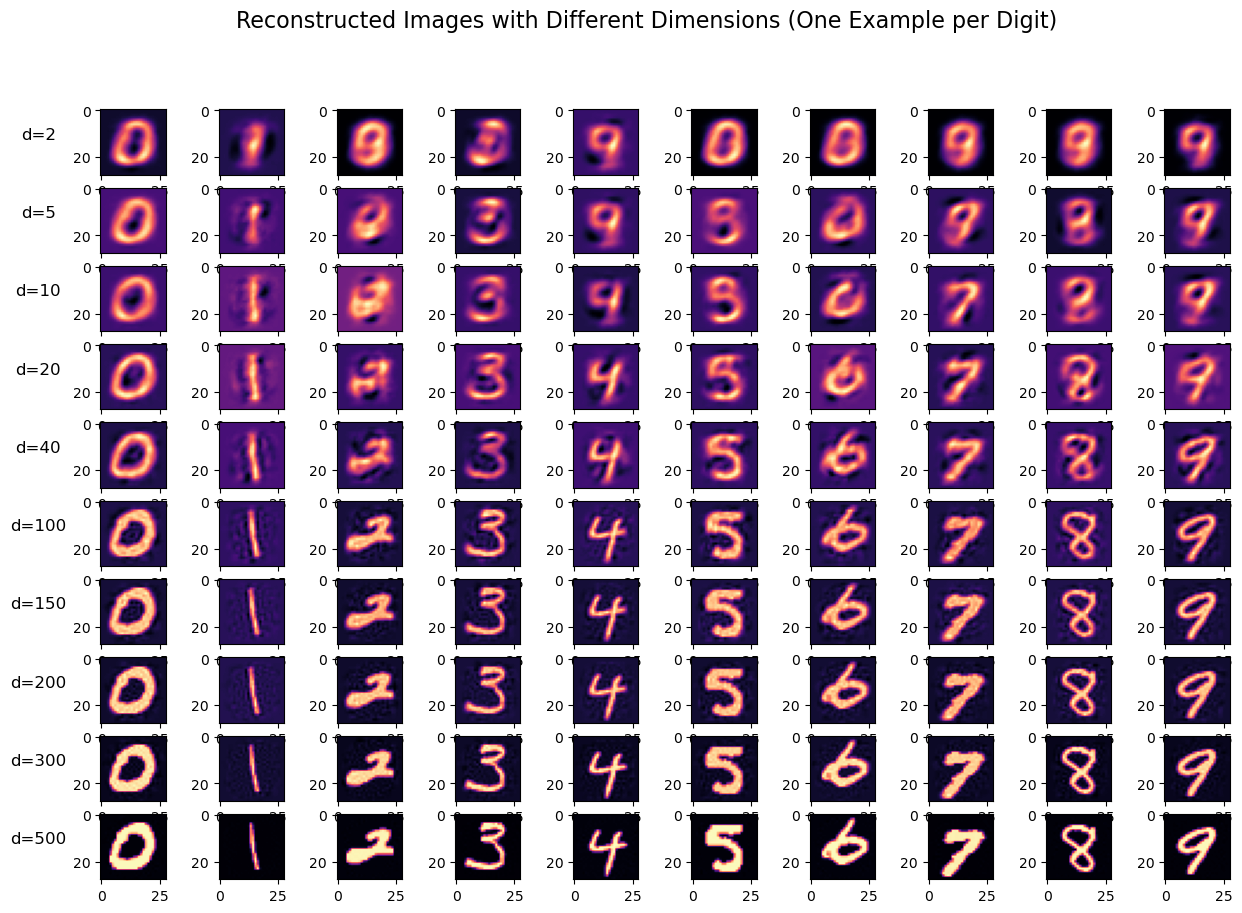

In [25]:
# Reconstruct images with varying dimensions and show one example of each digit
dimensions = [2, 5, 10, 20, 40, 100, 150, 200, 300, 500]
fig, axes = plt.subplots(len(dimensions), 10, figsize=(15, 10))

for i, d in enumerate(dimensions):
    reduced_data, pcs, mean, _ = pca(X_selected, d)
    reconstructed_data = reconstruct_data(reduced_data, pcs, mean)
    for digit in range(10):
        # Find the index of the first image for the current digit
        digit_index = np.where(y_selected == (digit))[0][0]
        axes[i, digit].imshow(reconstructed_data[digit_index].reshape(28, 28), cmap='magma')
        axes[i, digit].axis('on')
    axes[i, 0].set_ylabel(f"d={d}", fontsize=12, rotation=0, labelpad=25)
plt.suptitle("Reconstructed Images with Different Dimensions (One Example per Digit)", fontsize=16)
plt.show()

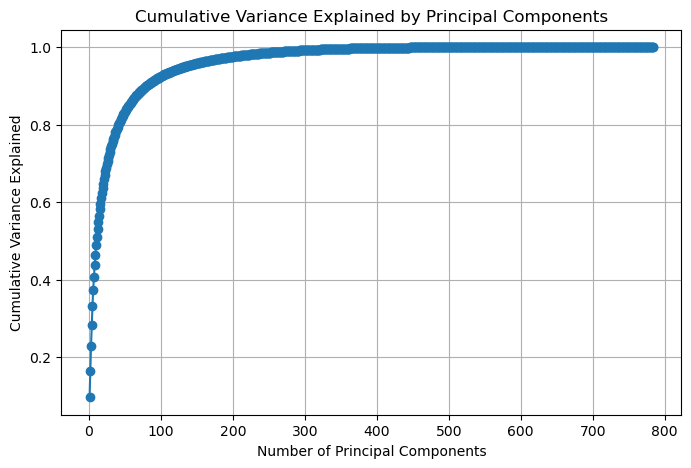

Optimal number of dimensions for 95.0% variance: 134


In [26]:
# Variance explained by each principal component
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid()
plt.show()

# Choose `d` where ~95% variance is retained
retain=0.95
optimal_d = np.argmax(cumulative_variance >= retain) + 1
print(f"Optimal number of dimensions for {retain*100}% variance: {optimal_d}")
